In [2]:
!pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/seoyunje/cxr-embedding')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/cxr-embedding


100%|██████████| 72.5M/72.5M [00:00<00:00, 135MB/s]


In [3]:
import gc
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

import tensorflow as tf
from tensorflow.keras import *

import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score


import warnings
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_EMBEDDINGS_FROM = '/content/cxr-embedding/'

tensorflow version:  2.17.0
Using 0 GPUs


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
df_train = pd.read_csv(f'{LOAD_EMBEDDINGS_FROM}effnet_train.csv')

print('Shape of Train: ', df_train.shape)
print(display(df_train.head()))

Shape of Train:  (4000, 1294)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,embedding_1270,embedding_1271,embedding_1272,embedding_1273,embedding_1274,embedding_1275,embedding_1276,embedding_1277,embedding_1278,embedding_1279
0,00011831_003.png,Pneumothorax,3,11831,57,F,AP,2500,2048,0.168000,...,-0.043413,-0.177190,-0.060664,0.336708,0.029756,0.423170,0.067867,-0.132843,0.215147,0.014451
1,00026828_007.png,Atelectasis,7,26828,52,M,PA,2992,2991,0.143000,...,-0.026030,-0.212357,-0.022640,0.250034,0.004761,0.392500,0.042008,-0.215910,0.196017,0.045607
2,00020983_004.png,Cardiomegaly|Effusion,4,20983,43,M,AP,3028,2544,0.139000,...,0.050357,-0.133323,-0.013561,-0.035220,0.067420,0.047772,0.084724,-0.180257,-0.060201,0.085671
3,00019010_000.png,Cardiomegaly|Effusion,0,19010,25,M,PA,2021,2021,0.194311,...,-0.041460,-0.176459,-0.021935,0.270372,0.040208,0.298737,0.010739,-0.187055,-0.028953,0.025067
4,00007034_016.png,Effusion,16,7034,31,F,PA,2021,2021,0.194311,...,-0.044755,-0.189025,0.037452,0.253462,0.052200,0.104253,0.039526,-0.217327,0.076898,0.031775


None


In [5]:
df_train = pd.read_csv(f'{LOAD_EMBEDDINGS_FROM}effnet_train.csv')

print('Shape of Train: ', df_train.shape)
print(display(df_train.head()))

Shape of Train:  (4000, 1294)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,embedding_1270,embedding_1271,embedding_1272,embedding_1273,embedding_1274,embedding_1275,embedding_1276,embedding_1277,embedding_1278,embedding_1279
0,00011831_003.png,Pneumothorax,3,11831,57,F,AP,2500,2048,0.168000,...,-0.043413,-0.177190,-0.060664,0.336708,0.029756,0.423170,0.067867,-0.132843,0.215147,0.014451
1,00026828_007.png,Atelectasis,7,26828,52,M,PA,2992,2991,0.143000,...,-0.026030,-0.212357,-0.022640,0.250034,0.004761,0.392500,0.042008,-0.215910,0.196017,0.045607
2,00020983_004.png,Cardiomegaly|Effusion,4,20983,43,M,AP,3028,2544,0.139000,...,0.050357,-0.133323,-0.013561,-0.035220,0.067420,0.047772,0.084724,-0.180257,-0.060201,0.085671
3,00019010_000.png,Cardiomegaly|Effusion,0,19010,25,M,PA,2021,2021,0.194311,...,-0.041460,-0.176459,-0.021935,0.270372,0.040208,0.298737,0.010739,-0.187055,-0.028953,0.025067
4,00007034_016.png,Effusion,16,7034,31,F,PA,2021,2021,0.194311,...,-0.044755,-0.189025,0.037452,0.253462,0.052200,0.104253,0.039526,-0.217327,0.076898,0.031775


None


In [6]:
!pip install -q umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00


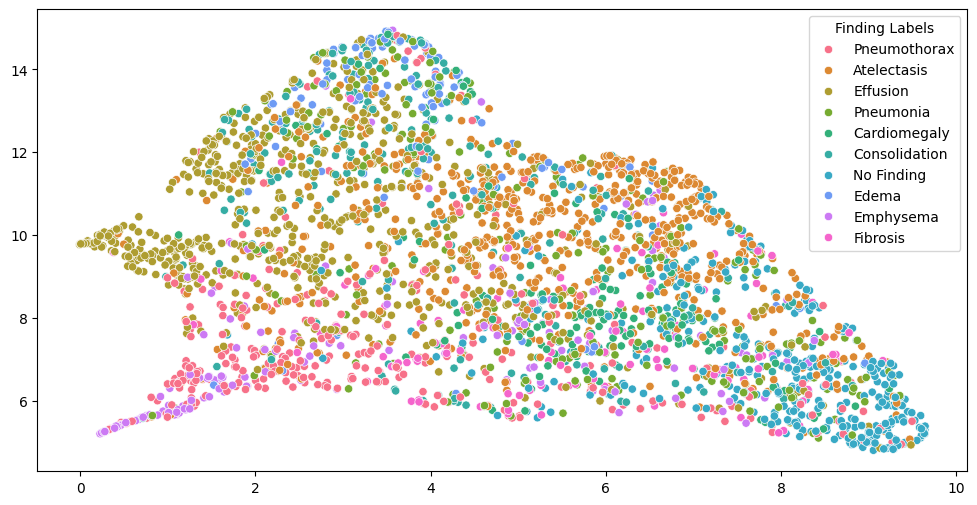

CPU times: user 54.8 s, sys: 690 ms, total: 55.5 s
Wall time: 1min 18s


In [7]:
%%time

import umap.umap_ as umap
umap = umap.UMAP()

plt.figure(figsize=(12,6))
embedding = df_train[~df_train['Finding Labels'].str.contains('\|', regex=True)]
embed_2d = umap.fit_transform(embedding.drop(columns=embedding.columns[:14]))
sns.scatterplot(x=embed_2d[:,0], y=embed_2d[:,1], hue=df_train[~df_train['Finding Labels'].str.contains('\|', regex=True)]['Finding Labels'], palette=sns.color_palette("husl", n_colors=10), sizes=2)

plt.show()

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(embed_2d)
embedding['cluster'] = kmeans.labels_

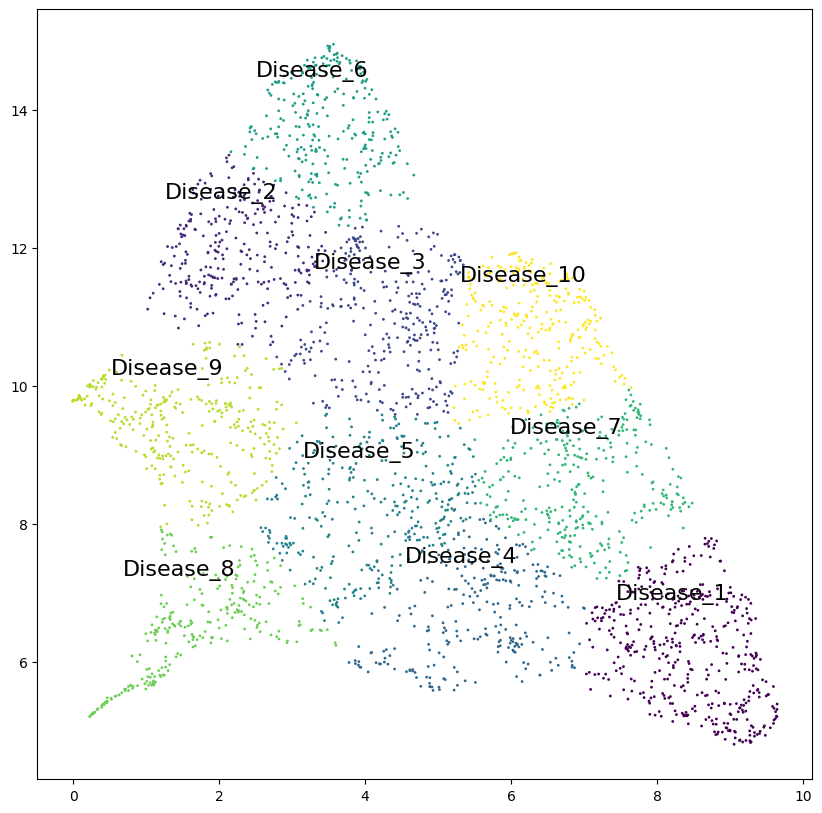

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=embedding['cluster'])

centers = kmeans.cluster_centers_

for k in range(len(centers)):
    plt.text(centers[k,0]-1,centers[k,1]+0.75,f'Disease_{k+1}',size=16)

plt.show()